In [2]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Flatten, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [31]:
import json
data = [json.loads(line) for 
        line in open("/content/Sarcasm_Headlines_Dataset.json", 'r')]


In [32]:
new_df = pd.DataFrame.from_dict(data) 

In [33]:
new_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [34]:
new_df2 = new_df.drop(['article_link'],axis=1)

In [35]:
new_df2.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [36]:
new_df2["headline_len"] = new_df2["headline"].str.len()

In [37]:
new_df2.head()

,headline,is_sarcastic,headline_len
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


In [38]:
max_features = 10000
maxlen = 25
embedding_size = 200

In [39]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(new_df2['headline'])

In [40]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [41]:
train_seqs = tokenizer.texts_to_sequences(new_df2['headline'])

In [42]:
X = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=maxlen)

In [43]:
Y = new_df2["is_sarcastic"].values

In [44]:
print(type(Y))

<class 'numpy.ndarray'>


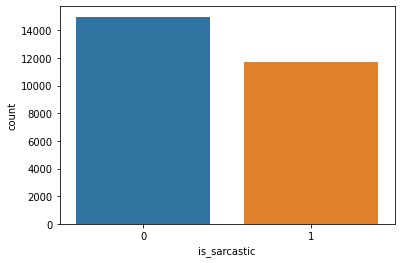

In [45]:
sns.countplot(x='is_sarcastic',data=new_df2);

In [46]:
tokenizer.word_index

{'<unk>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'this': 19,
 'by': 20,
 'after': 21,
 'up': 22,
 'out': 23,
 'be': 24,
 'how': 25,
 'as': 26,
 'it': 27,
 'that': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'his': 32,
 'what': 33,
 'he': 34,
 'all': 35,
 'just': 36,
 'who': 37,
 'has': 38,
 'will': 39,
 'more': 40,
 'one': 41,
 'into': 42,
 'report': 43,
 'year': 44,
 'why': 45,
 'have': 46,
 'area': 47,
 'over': 48,
 'donald': 49,
 'u': 50,
 'day': 51,
 'says': 52,
 's': 53,
 'can': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'her': 59,
 "trump's": 60,
 'old': 61,
 'no': 62,
 'get': 63,
 'off': 64,
 'an': 65,
 'life': 66,
 'people': 67,
 'obama': 68,
 'now': 69,
 'house': 70,
 'still': 71,
 "'": 72,
 'women': 73,
 'make': 74,
 'was': 75,
 'than': 76,
 'white': 77,
 'back': 78,
 'my': 79,
 'i': 80,
 'clinton': 81,
 '

In [47]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29660


In [48]:
EMBEDDING_FILE = '/content/glove.6B.200d.txt'

In [ ]:
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd

In [54]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector


In [56]:
lstm_out = 196

# define the model
model = Sequential()
model.add(Embedding(num_words,
                    embedding_size,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [57]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 200)           5932000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 200)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 392)              622496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 1)                 393       
                                                                 
Total params: 6,554,889
Trainable params: 622,889
Non-tr

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(21367, 25) (21367,)
(5342, 25) (5342,)


In [59]:
batch_size = 64
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, 
                    verbose = 1, validation_split=0.1)

Epoch 1/10
301/301 [==============================] - 164s 513ms/step - loss: 0.5521 - accuracy: 0.7124 - val_loss: 0.4435 - val_accuracy: 0.7946
Epoch 2/10
301/301 [==============================] - 155s 515ms/step - loss: 0.4536 - accuracy: 0.7822 - val_loss: 0.3750 - val_accuracy: 0.8386
Epoch 3/10
301/301 [==============================] - 153s 509ms/step - loss: 0.3990 - accuracy: 0.8142 - val_loss: 0.3484 - val_accuracy: 0.8409
Epoch 4/10
301/301 [==============================] - 156s 518ms/step - loss: 0.3628 - accuracy: 0.8330 - val_loss: 0.3291 - val_accuracy: 0.8563
Epoch 5/10
301/301 [==============================] - 153s 507ms/step - loss: 0.3401 - accuracy: 0.8500 - val_loss: 0.3080 - val_accuracy: 0.8591
Epoch 6/10
301/301 [==============================] - 153s 509ms/step - loss: 0.3162 - accuracy: 0.8603 - val_loss: 0.2977 - val_accuracy: 0.8708
Epoch 7/10
301/301 [==============================] - 164s 544ms/step - loss: 0.3028 - accuracy: 0.8686 - val_loss: 0.2893 -

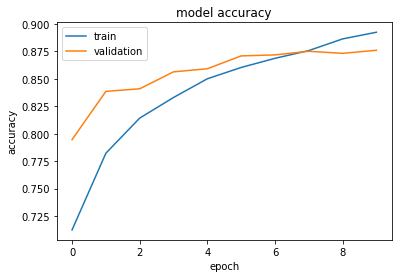

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

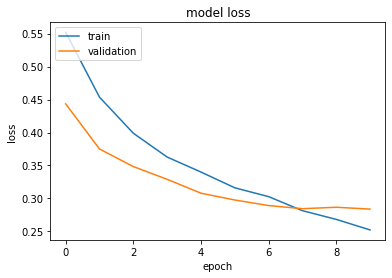

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [62]:
loss, accuracy = model.evaluate(X_test, Y_test)

167/167 [==============================] - 8s 45ms/step - loss: 0.3001 - accuracy: 0.8751


In [63]:
print(f'My test loss is {loss*100:.2f}% and test accuracy is {accuracy*100:.2f}%')

My test loss is 30.01% and test accuracy is 87.51%


In [66]:
def model_Evaluate(model,test_data):
    # Predict values for Test dataset
    y_pred = model.predict(test_data)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Positive','Negative']
    group_names = ['True Pos','False Neg','True Neg','False Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'crest',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 5)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 5)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 10)

In [73]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

167/167 [==============================] - 12s 69ms/step


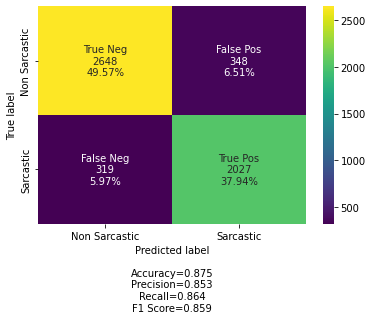

In [75]:
cf_matrix = confusion_matrix(Y_test, (model.predict(X_test) > 0.5).astype("int32"))
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non Sarcastic','Sarcastic']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='viridis')

167/167 [==============================] - 8s 49ms/step


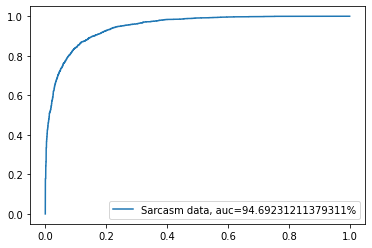

In [82]:
np.set_printoptions(precision=2)
y_pred_proba = (model.predict(X_test))
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Sarcasm data, auc="+str(auc*100)+"%")
plt.legend(loc=4)
plt.show();

In [ ]:
!jupyter nbconvert to -html ""